In [1]:
from google.colab import drive
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

In [2]:
#!pip install datasets

In [2]:
# Step 1: Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 🔐 Hugging Face Token for gated model access
HF_TOKEN = "REDACTED"

In [4]:
from huggingface_hub import login
login(token=HF_TOKEN)

In [5]:
from transformers import AutoModelForCausalLM

base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    token=HF_TOKEN,
    device_map="auto",
    torch_dtype=torch.float16
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "/content/drive/MyDrive/AI_Mock_Project/adapter",
    use_fast=True
)
tokenizer.pad_token = tokenizer.eos_token

LOSS Curve. These values are table from the Finetune file of Mistral (Table)

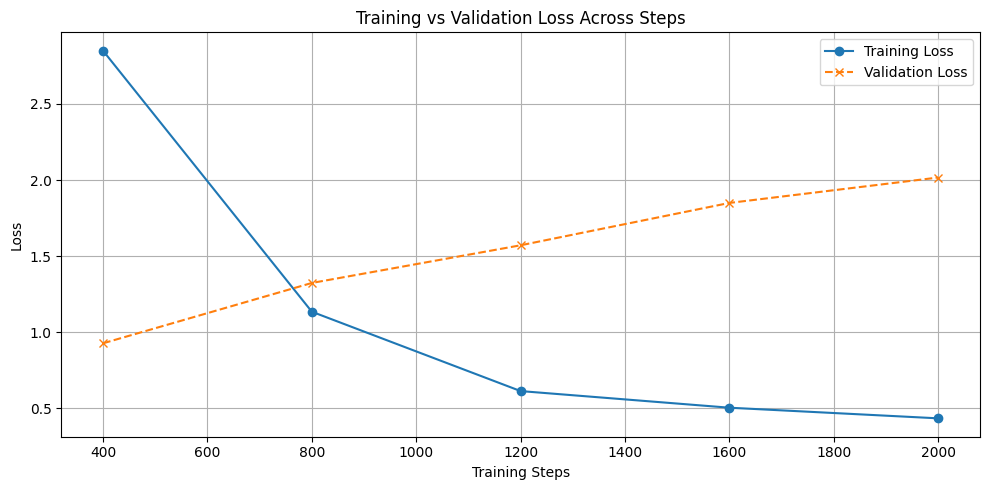

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame from provided values
data = {
    "Step": [400, 800, 1200, 1600, 2000],
    "Training Loss": [2.849400, 1.135300, 0.614200, 0.505000, 0.435200],
    "Validation Loss": [0.927963, 1.324228, 1.571713, 1.849846, 2.016637]
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Training Loss"], marker="o", label="Training Loss")
plt.plot(df["Step"], df["Validation Loss"], marker="x", linestyle="--", label="Validation Loss")

plt.title("Training vs Validation Loss Across Steps")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Relevance

In [7]:
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer, util
import pandas as pd
import json
from tqdm import tqdm

In [8]:
# Correct path to eval file
EVAL_FILE = "/content/drive/MyDrive/AI_Mock_Project/eval.jsonl"

# Load eval lines
with open(EVAL_FILE, "r", encoding="utf-8") as f:
    lines = [json.loads(l.strip()) for l in f.readlines()]

# Build prompts and references
samples = []
for ex in lines[:100]:  # Limit to 100 samples
    prompt = ""
    for m in ex["messages"][:-1]:
        prompt += f"<|{m['role']}|>{m['content']}\n"
    target = ex["messages"][-1]["content"]
    samples.append((prompt.strip(), target.strip()))


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

BASE_MODEL = "mistralai/Mistral-7B-Instruct-v0.2"
ADAPTER_PATH = "/content/drive/MyDrive/AI_Mock_Project/adapter"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load base + adapter model
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL, device_map="auto", torch_dtype=torch.float16
)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [10]:
generated = []

for prompt, reference in tqdm(samples, desc="Generating"):
    full_prompt = prompt + "<|assistant|>"
    inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, max_length=2048).to("cuda")

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=120,
            temperature=0.9,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    reply = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    generated.append((reply, reference))

Generating: 100%|██████████| 100/100 [13:20<00:00,  8.00s/it]


In [11]:
# Load pre-trained embedding model (you can try others like 'all-MiniLM-L6-v2' too)
embedder = SentenceTransformer("all-MiniLM-L12-v2")

# Separate generated and reference outputs
gen_texts = [gen for gen, ref in generated]
ref_texts = [ref for gen, ref in generated]

# Compute embeddings
gen_embeddings = embedder.encode(gen_texts, convert_to_tensor=True, batch_size=16, show_progress_bar=True)
ref_embeddings = embedder.encode(ref_texts, convert_to_tensor=True, batch_size=16, show_progress_bar=True)

# Compute cosine similarities
cosine_scores = util.cos_sim(gen_embeddings, ref_embeddings).diagonal().cpu().numpy()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

BLEU Score

In [12]:
!pip install -q evaluate
import evaluate

# Load BLEU metric from Hugging Face Evaluate library
bleu = evaluate.load("bleu")

# Ensure `generated` is a list of (generated_text, reference_text)
# Example: [('The model's answer', 'Ground truth'), ...]

# Prepare the inputs
predictions = [gen for gen, ref in generated]
references = [[ref] for gen, ref in generated]  # BLEU expects a list of references for each prediction

# Compute BLEU
bleu_score = bleu.compute(predictions=predictions, references=references)

# Display result
print(f" BLEU Score: {bleu_score['bleu']:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


 BLEU Score: 0.0671


Question generation

Single loop

In [13]:
import re

def system_ask(domain=None):
    if domain:
        return f"You are a rigorous {domain} interviewer. Ask me a domain-specific question."
    return "You are a rigorous technical interviewer. Ask me a domain-specific question."

def generate_question(domain=None):
    prompt = f"<s>[INST] {system_ask(domain)} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    prompt_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        out = model.generate(**inputs, **COMMON_KWARGS)

    gen_ids = out[0][prompt_len:]
    text = tokenizer.decode(gen_ids, skip_special_tokens=True)

    first_line = text.strip().split("\n")[0]
    question = re.sub(r"^(?:Q\d+[:\s]*|Question[:\s]*)", "", first_line).strip()
    question = re.split(r"\b(?:User|Feedback|Follow-?up)\b", question)[0].strip()
    return question

def system_feedback(domain=None):
    base = (
        "You are an AI interviewer. Your task is:\n"
        "1. Evaluate the user's answer and provide helpful, constructive feedback.\n"
        "2. Ask a follow-up question — it can either continue the same topic or transition to a new domain from the list below.\n\n"
        "Available domains: Excel, Python, NoSQL, SQL, Python coding, Behavioral, Data Science, Probability, Machine Learning, Deep Learning, Statistics.\n"
        "Do NOT repeat the candidate’s answer verbatim."
    )
    return f"You are a rigorous {domain} interviewer. " + base if domain else base

def generate_feedback(question, answer, domain=None):
    prompt = (
        f"<s>[INST] {system_feedback(domain)}\n\n"
        f"Question: {question}\n"
        f"Candidate Answer: {answer} [/INST]"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to("cuda")

    with torch.no_grad():
        out = model.generate(**inputs, **COMMON_KWARGS)

    return tokenizer.decode(out[0], skip_special_tokens=True).strip()

def get_feedback_and_followup(question, answer, domain=None):
    raw = generate_feedback(question, answer, domain)

    # Remove exact known prompt parts if echoed
    raw = raw.replace(system_feedback(domain), "").strip()
    raw = re.sub(r"\[INST\](.*?)\[/INST\]", "", raw, flags=re.DOTALL).strip()
    raw = raw.replace(f"Question: {question}", "").strip()
    raw = raw.replace(f"Candidate Answer: {answer}", "").strip()

    # Also remove any leading "Question:", "Candidate Answer:" in case format shifts
    raw = re.sub(r"^(Question|Candidate Answer)[:\s]*", "", raw, flags=re.IGNORECASE).strip()

    # Now extract feedback vs follow-up
    marker = re.search(r'(?:\r?\n)?Follow[- ]?up[:\s]*', raw, re.IGNORECASE)
    if marker:
        feedback = raw[:marker.start()].strip()
        followup = raw[marker.end():].strip()
    else:
        feedback = raw.strip()
        followup = ""

    return feedback, followup

In [14]:
# Generation settings
COMMON_KWARGS = dict(
    max_new_tokens=150,
    temperature=0.9,
    top_p=0.9,
    top_k=40,
    repetition_penalty=1.05,
    no_repeat_ngram_size=3,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id  # required for open-ended generation
)

In [17]:
q = generate_question("Data Science")
print("Q:", q)

a = input("A: ")

Q: Can you describe the process of building a sentiment analysis model from scratch, including feature engineering and model training? [/Inst]
A: To build a sentiment analysis model from scratch, start by collecting and preprocessing text data (e.g., tokenization, stopword removal), then convert it into numerical features using techniques like TF-IDF or Word2Vec. Train a model such as Logistic Regression or an LSTM on labeled data, and evaluate it using metrics like accuracy and F1 score.


In [18]:
feedback, followup = get_feedback_and_followup(q, a, domain="Data Science")
print("\n Feedback:\n", feedback)
print("\n Follow-up Question:\n", followup)


 Feedback:
 Your answer is quite comprehensive and shows a good understanding of the basic steps involved in building a sentiments analysis model. However, you could improve your answer by providing more specific details. For instance, how do you perform tokenization and stopword removing? What are TF-IDs and how do they help in feature engineering? Also, it would be good to know what are the pros and cons of using Logistic regression and LSTM for this task.

 Follow-up Question:
 Could you elaborate more on the specific techniques you use for text preprocessing, like tokenizationand stopword removed? And also, would you mind discussing the differences between using Logistics Regression andLSTM for sentiment analysis?


================ LOOP CHECK ==================== to answer the followup question too =====

In [8]:
import re
import torch

# === Prompt Templates ===
def system_ask(domain=None):
    return f"You are a rigorous {domain} interviewer. Ask me a domain-specific question." if domain else \
           "You are a rigorous technical interviewer. Ask me a domain-specific question."

def system_feedback(domain=None):
    return (
        f"You are a rigorous {domain} interviewer. "
        "You are an AI interviewer. Your task is:\n"
        "1. Evaluate the user's answer and provide helpful, constructive feedback.\n"
        "2. Ask a follow-up question — it can either continue the same topic or transition to a new domain from the list below.\n\n"
        "Available domains: Excel, Python, NoSQL, SQL, Python coding, Behavioral, Data Science, Probability, Machine Learning, Deep Learning, Statistics.\n"
        "Do NOT repeat the candidate’s answer verbatim."
    )


In [9]:
COMMON_KWARGS = dict(
    max_new_tokens=150,
    temperature=0.9,
    top_p=0.9,
    top_k=40,
    repetition_penalty=1.05,
    no_repeat_ngram_size=3,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id  # set after loading tokenizer
)


In [10]:
def generate_question(domain=None):
    prompt = f"<s>[INST] {system_ask(domain)} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    prompt_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        out = model.generate(**inputs, **COMMON_KWARGS)

    gen_ids = out[0][prompt_len:]
    text = tokenizer.decode(gen_ids, skip_special_tokens=True)

    first_line = text.strip().split("\n")[0]
    first_line = re.sub(r"^Q(?:uestion)?\.?\s*\d*[:\-]?\s*", "", first_line, flags=re.IGNORECASE).strip()
    question = re.split(r"\b(?:User|Feedback|Follow-?up)\b", first_line)[0].strip()
    return question

def generate_feedback(question, answer, domain=None):
    prompt = (
        f"<s>[INST] {system_feedback(domain)}\n\n"
        f"Question: {question}\n"
        f"Candidate Answer: {answer} [/INST]"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to("cuda")
    with torch.no_grad():
        out = model.generate(**inputs, **COMMON_KWARGS)
    return tokenizer.decode(out[0], skip_special_tokens=True).strip()

def get_feedback_and_followup(question, answer, domain=None):
    raw = generate_feedback(question, answer, domain)

    raw = raw.replace(system_feedback(domain), "").strip()
    raw = raw.replace(f"Question: {question}", "").replace(f"Candidate Answer: {answer}", "").strip()
    raw = re.sub(r"\[INST\](.*?)\[/INST\]", "", raw, flags=re.DOTALL).strip()
    raw = re.sub(r"^(Question|Candidate Answer)[:\s]*", "", raw, flags=re.IGNORECASE).strip()

    marker = re.search(r'(?:\r?\n)?Follow[- ]?up[:\s]*', raw, re.IGNORECASE)
    if marker:
        feedback = raw[:marker.start()].strip()
        followup = raw[marker.end():].strip()
    else:
        feedback = raw.strip()
        followup = ""

    followup = re.sub(r"\(.*?domain.*?\)", "", followup, flags=re.IGNORECASE).strip()

    return feedback, followup


In [11]:
def run_interview_turn(q=None, domain="Data Science"):
    if q is None:
        q = generate_question(domain)
    print("\n Question:\n", q)

    a = input("\n Your Answer: ")

    feedback, followup = get_feedback_and_followup(q, a, domain)

    print("\n Feedback:\n", feedback)
    print("\n Follow-up Question:\n", followup)

    return followup  # promote to next turn


In [12]:
# Start with the first question
next_q = run_interview_turn()


 Question:
 What is the difference between bias and variance in a machine learning model, and how do they impact model performance? [/Inst]


KeyboardInterrupt: Interrupted by user

In [ ]:
# Then run this again for follow-up turns:
next_q = run_interview_turn(q=next_q)